## TP53 Mutation Hotspot Analyzer  
### **Course:** 03-701 Practical Computing for Biologist 
### **Name:** Arunannamalai Sujatha Bharath Raj
### **Andrew ID:** asujatha
### **Due:** Oct 13, 2025 (11:59 PM ET)  

## 1. Setup and Library Initialization

In [3]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

from Bio import Entrez, SeqIO
from Bio.Seq import Seq
from io import StringIO

# Configuring matplotlib for inline display
%matplotlib inline

# NCBI access
Entrez.email = "arunsb@cmu.edu" #Andrew account linked to Entrez

## 2. Sequence Retrieval via Biopython 
Fetching the canonical TP53 coding sequence (RefSeq NM_000546.6) from NCBI using Biopython Entrez, caching a local FASTA copy, and translating the coding DNA to obtain the reference TP53 protein.

In [4]:
def fetch_seq_fasta(ncbi_id = "NM_000546.6"):
    """
    The function retrieves the TP53 coding sequence from NCBI RefSeq using Biopython's Entrez.
    and returns SeqRecord object containing the nucleotide sequence.
    """
    try:
        # Fetching the FASTA text from NCBI nucleotide database
        handle = Entrez.efetch(db = "nucleotide", id = ncbi_id, rettype = "fasta", retmode = "text")
        fas_txt = handle.read()
        handle.close()

        # Parsing the FASTA string into a SeqRecord
        record = SeqIO.read(StringIO(fas_txt), "fasta")
        print("Successfully fetched {} ({} nt)".format(ncbi_id, len(record.seq)))
        return record
    except Exception as e:
        raise RuntimeError("Unable to fetch TP53 sequence: {}".format(e))

# Fetching nucleotide sequence
tp53_record = fetch_seq_fasta()

# Trimming Coding DNA sequence (CDS) to a multiple of 3 bases in order to avoid 
# partial-codon translation warnings
cds_len = len(tp53_record.seq)
trim_len = cds_len - (cds_len % 3)
seq_trimmed = tp53_record.seq[:trim_len]

# Translate to protein (stop at first stop codon)
tp53_protein = Seq(str(seq_trimmed)).translate(to_stop=True)

print("Protein length (aa): {}".format(len(tp53_protein)))
print(str(tp53_protein)[:60])

Successfully fetched NM_000546.6 (2512 nt)
Protein length (aa): 31
LKSLEPPSREQVAAGLRGHFAFGLGACFPRR


## 3  ClinVar Variant Retrieval
Downloading the ClinVar variant summary table (tab-delimited, gzipped) directly from NCBI, filter to TP53 on the desired assembly, and extract the `Protein_Change` column for downstream parsing.

In [14]:
def load_clinvar_tp53_from_summary(url=None, assembly="GRCh38"):
    """
    Load TP53 variants from ClinVar's tab-delimited summary (gzipped).
    Extract readable cancer/condition names from PhenotypeList (if available),
    falling back to ClinicalSignificance or Name text.
    """
    import re
    if url is None:
        url = "https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz"

    # Read header and detect columns
    header = pd.read_csv(url, sep="\t", compression="infer", nrows=0, dtype=str)
    cols = list(header.columns)
    print("ClinVar header detected with {} columns".format(len(cols)))

    def find_col(cols, patterns):
        for p in patterns:
            for c in cols:
                if re.search(p, c, flags=re.IGNORECASE):
                    return c
        return None

    # Find key columns dynamically
    gene_col = find_col(cols, ["GeneSymbol"])
    assembly_col = find_col(cols, ["Assembly"])
    name_col = find_col(cols, ["Name"])
    prot_col = find_col(cols, ["Protein", "HGVS_p"])
    clin_col = find_col(cols, ["ClinicalSignificance"])
    pheno_col = find_col(cols, ["PhenotypeList", "Condition", "Trait"])

    # Select only the columns that exist
    usecols = [c for c in [gene_col, assembly_col, name_col, prot_col, clin_col, pheno_col] if c is not None]

    df_all = pd.read_csv(url, sep="\t", compression="infer", usecols=usecols, dtype=str, low_memory=False)

    # Filter TP53 variants for the correct genome assembly
    df = df_all[df_all[gene_col] == "TP53"].copy()
    if assembly_col in df.columns:
        df = df[df[assembly_col] == assembly].copy()

    # Extract Protein_Change from either Protein or Name
    if prot_col in df.columns:
        df["Protein_Change"] = df[prot_col]
    else:
        df["Protein_Change"] = df[name_col].astype(str).str.extract(r"(p\.[A-Za-z0-9*]+)", expand=False)
    df = df[df["Protein_Change"].astype(str).str.startswith("p.")].copy()

    # Extract readable cancer/condition names
    if pheno_col in df.columns:
        cleaned = df[pheno_col].astype(str)
        cleaned = cleaned.str.replace(r"(Gene|MedGen|OMIM|Orphanet|MONDO|HP|MeSH|DOID)[:0-9,]+", "", regex=True)
        cleaned = cleaned.str.replace(r"\|+", ", ", regex=True).str.strip(",; |")
        df["Cancer_Type"] = cleaned
    elif clin_col in df.columns:
        df["Cancer_Type"] = df[clin_col]
    else:
        df["Cancer_Type"] = ""

    df["Cancer_Type"] = df["Cancer_Type"].fillna("").astype(str)
    df = df[df["Cancer_Type"].str.strip().ne("")].copy()
    df = df[~df["Cancer_Type"].str.contains("not provided", case=False, na=False)]
    df = df[~df["Cancer_Type"].str.contains("NA", case=False, na=False)]

    df["Source"] = "ClinVar"
    df = df[["Protein_Change", "Cancer_Type", "Source"]].drop_duplicates().reset_index(drop=True)

    print("Loaded {} TP53 variants with {} unique Cancer_Type entries".format(
        len(df), df["Cancer_Type"].nunique()))
    return df

# Execute
df = load_clinvar_tp53_from_summary(assembly="GRCh38")
df.head(20)

ClinVar header detected with 43 columns
Loaded 2150 TP53 variants with 245 unique Cancer_Type entries


,Protein_Change,Cancer_Type,Source
0,p.Val272Leu,"Li-Fraumeni syndrome 1, Hereditary cancer-pred...",ClinVar
1,p.Asn210fs,Li-Fraumeni syndrome 1,ClinVar
2,p.Lys120Ter,"Li-fraumeni-like syndrome, Hereditary cancer-p...",ClinVar
3,p.Leu35Phe,"Carcinoma of pancreas, Li-Fraumeni syndrome",ClinVar
4,p.Leu257Gln,"Li-fraumeni-like syndrome, Ovarian neoplasm, H...",ClinVar
5,p.Lys292Ile,"Li-Fraumeni syndrome 1, Hereditary cancer-pred...",ClinVar
6,p.Ala161fs,"Choroid plexus papilloma, Bone osteosarcoma",ClinVar
7,p.Glu285Val,"Choroid plexus carcinoma, ADRENOCORTICAL CARCI...",ClinVar
8,p.Arg181Leu,"Glioma susceptibility 1, Li-Fraumeni syndrome,...",ClinVar
9,p.Ser240,not specified,ClinVar


## 4. Variant Parsing  
Parse protein-level HGVS notations to extract amino-acid positions and classify each TP53 variant as missense, nonsense, synonymous, or frameshift.

In [26]:
AA_THREE_TO_ONE = {
    'Ala':'A','Arg':'R','Asn':'N','Asp':'D','Cys':'C','Gln':'Q','Glu':'E','Gly':'G',
    'His':'H','Ile':'I','Leu':'L','Lys':'K','Met':'M','Phe':'F','Pro':'P','Ser':'S',
    'Thr':'T','Trp':'W','Tyr':'Y','Val':'V','Ter':'*','Stop':'*'
}

# Accept both bare and parenthesized HGVS forms
RE_ONE        = re.compile(r'^\(?p\.([A-Z*])(\d+)([A-Z*])\)?$')
RE_THREE      = re.compile(r'^\(?p\.([A-Z][a-z]{2})(\d+)([A-Z][a-z]{2}|\*)\)?$')

# Frameshift patterns (e.g. p.Asn210fs, p.N210fs, p.(Arg196fs))
RE_FS_ONE     = re.compile(r'^\(?p\.([A-Z*])(\d+)fs', re.IGNORECASE)
RE_FS_THREE   = re.compile(r'^\(?p\.([A-Z][a-z]{2})(\d+)fs', re.IGNORECASE)

def parse_hgvs_p(p):
    """Extract AA position, residues, and classify consequence (missense, nonsense, synonymous, frameshift)."""
    try:
        p = p.strip()
    except Exception:
        return {"AA_Pos": None, "Ref_AA": None, "Alt_AA": None, "Consequence": None}

    if p == "p.=":
        return {"AA_Pos": None, "Ref_AA": None, "Alt_AA": None, "Consequence": "synonymous"}

    # Frameshift
    m = RE_FS_ONE.match(p)
    if m:
        ref1, pos = m.groups()
        return {"AA_Pos": int(pos), "Ref_AA": ref1, "Alt_AA": None, "Consequence": "frameshift"}
    m = RE_FS_THREE.match(p)
    if m:
        ref3, pos = m.groups()
        ref1 = AA_THREE_TO_ONE.get(ref3)
        return {"AA_Pos": int(pos), "Ref_AA": ref1, "Alt_AA": None, "Consequence": "frameshift"}

    # Missense / Nonsense
    m = RE_ONE.match(p)
    if m:
        ref, pos, alt = m.groups()
        pos = int(pos)
        cons = "nonsense" if alt == "*" else ("synonymous" if ref == alt else "missense")
        return {"AA_Pos": pos, "Ref_AA": ref, "Alt_AA": alt, "Consequence": cons}

    m = RE_THREE.match(p)
    if m:
        ref3, pos, alt3 = m.groups()
        pos = int(pos)
        ref = AA_THREE_TO_ONE.get(ref3)
        alt = "*" if alt3 in ("*", "Ter", "Stop") else AA_THREE_TO_ONE.get(alt3)
        if ref and alt:
            cons = "nonsense" if alt == "*" else ("synonymous" if ref == alt else "missense")
            return {"AA_Pos": pos, "Ref_AA": ref, "Alt_AA": alt, "Consequence": cons}

    # Fallback for complex types
    return {"AA_Pos": None, "Ref_AA": None, "Alt_AA": None, "Consequence": "other"}

# Parse all variants (no .apply)
records = [parse_hgvs_p(x) for x in df["Protein_Change"].tolist()]
parsed = pd.DataFrame.from_records(records)
df_parsed = pd.concat([df.reset_index(drop=True), parsed.reset_index(drop=True)], axis=1)

print("Parsed {} variants".format(len(df_parsed)))
df_parsed.head(12)

Parsed 2150 variants


,Protein_Change,Cancer_Type,Source,AA_Pos,Ref_AA,Alt_AA,Consequence
0,p.Val272Leu,"Li-Fraumeni syndrome 1, Hereditary cancer-pred...",ClinVar,272.0,V,L,missense
1,p.Asn210fs,Li-Fraumeni syndrome 1,ClinVar,210.0,N,None,frameshift
2,p.Lys120Ter,"Li-fraumeni-like syndrome, Hereditary cancer-p...",ClinVar,120.0,K,*,nonsense
3,p.Leu35Phe,"Carcinoma of pancreas, Li-Fraumeni syndrome",ClinVar,35.0,L,F,missense
4,p.Leu257Gln,"Li-fraumeni-like syndrome, Ovarian neoplasm, H...",ClinVar,257.0,L,Q,missense
5,p.Lys292Ile,"Li-Fraumeni syndrome 1, Hereditary cancer-pred...",ClinVar,292.0,K,I,missense
6,p.Ala161fs,"Choroid plexus papilloma, Bone osteosarcoma",ClinVar,161.0,A,None,frameshift
7,p.Glu285Val,"Choroid plexus carcinoma, ADRENOCORTICAL CARCI...",ClinVar,285.0,E,V,missense
8,p.Arg181Leu,"Glioma susceptibility 1, Li-Fraumeni syndrome,...",ClinVar,181.0,R,L,missense
9,p.Ser240,not specified,ClinVar,NaN,None,None,other


In [16]:
parsed = df["Protein_Change"].apply(parse_hgvs_p).apply(pd.Series)
df_parsed = pd.concat([df, parsed], axis=1)

print("Parsed {} variants; columns: {}".format(df_parsed.shape[0], list(df_parsed.columns)))
df_parsed

Parsed 2150 variants; columns: ['Protein_Change', 'Cancer_Type', 'Source', 'AA_Pos', 'Ref_AA', 'Alt_AA', 'Consequence']


,Protein_Change,Cancer_Type,Source,AA_Pos,Ref_AA,Alt_AA,Consequence
0,p.Val272Leu,"Li-Fraumeni syndrome 1, Hereditary cancer-pred...",ClinVar,272.0,V,L,missense
1,p.Asn210fs,Li-Fraumeni syndrome 1,ClinVar,210.0,None,None,other
2,p.Lys120Ter,"Li-fraumeni-like syndrome, Hereditary cancer-p...",ClinVar,120.0,K,*,nonsense
3,p.Leu35Phe,"Carcinoma of pancreas, Li-Fraumeni syndrome",ClinVar,35.0,L,F,missense
4,p.Leu257Gln,"Li-fraumeni-like syndrome, Ovarian neoplasm, H...",ClinVar,257.0,L,Q,missense
...,...,...,...,...,...,...,...
2145,p.His179,Hereditary cancer-predisposing syndrome,ClinVar,NaN,None,None,other
2146,p.Gln100Pro,Hereditary cancer-predisposing syndrome,ClinVar,100.0,Q,P,missense
2147,p.Glu286,Hereditary cancer-predisposing syndrome,ClinVar,NaN,None,None,other
2148,p.Ala159fs,Hereditary cancer-predisposing syndrome,ClinVar,159.0,None,None,other


## 5. Mutation Hotspot Visualization  
Aggregating parsed variants by amino-acid position and display recurrent mutation hotspots in TP53.

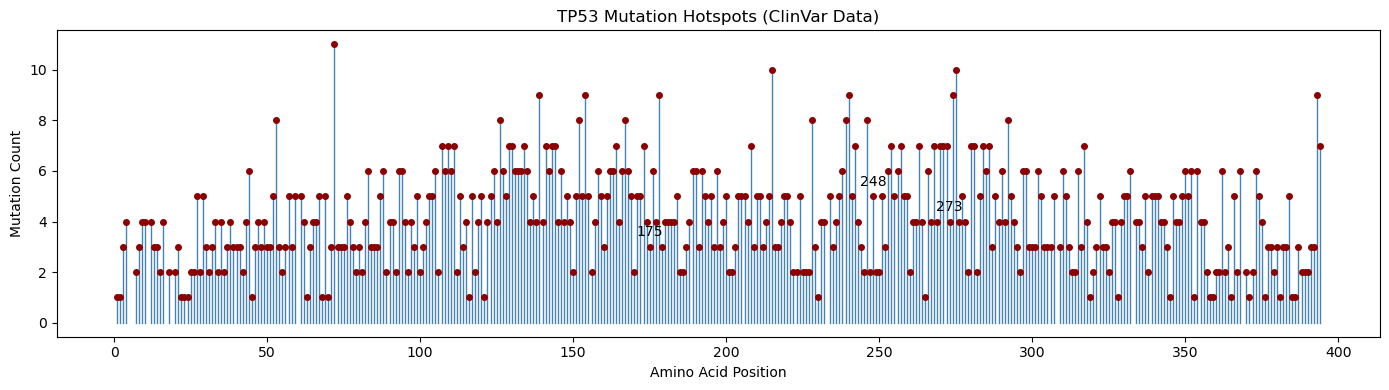

Consequence,AA_Pos,frameshift,missense,nonsense,Total_Count
65,72,1,10,0,11
267,275,3,6,1,10
208,215,4,6,0,10
266,274,2,7,0,9
171,178,5,4,0,9
147,154,4,5,0,9
232,240,3,6,0,9
132,139,3,5,1,9
382,393,3,6,0,9
231,239,4,3,1,8


In [27]:
# Keep valid amino-acid positions and selected mutation classes
df_plot = df_parsed.dropna(subset=["AA_Pos"]).copy()
df_plot["AA_Pos"] = df_plot["AA_Pos"].astype(int)
df_plot = df_plot[df_plot["Consequence"].isin(["missense", "nonsense", "frameshift"])]

summary = (
    df_plot.groupby(["AA_Pos", "Consequence"])
           .size()
           .unstack(fill_value=0)
           .reset_index()
)
summary["Total_Count"] = summary.drop(columns="AA_Pos").sum(axis=1)
summary = summary.sort_values("Total_Count", ascending=False)

plt.figure(figsize=(14, 4))
for pos, count in zip(summary["AA_Pos"], summary["Total_Count"]):
    plt.plot([pos, pos], [0, count], color="steelblue", lw=1)
    plt.plot(pos, count, "o", color="darkred", markersize=4)

plt.title("TP53 Mutation Hotspots (ClinVar Data)")
plt.xlabel("Amino Acid Position")
plt.ylabel("Mutation Count")

for hot in [175, 248, 273]:
    if hot in summary["AA_Pos"].values:
        y_val = summary.loc[summary["AA_Pos"] == hot, "Total_Count"].values[0]
        plt.text(hot, y_val + 0.3, str(hot), ha="center", va="bottom")

plt.tight_layout()
plt.show()

# Display top 10 hotspot residues
summary.head(10)

## 6. Summary Statistics  
Summarize the distribution of variant consequences and the top cancer associations for TP53.

=== Variant Consequence Distribution ===


,Consequence,Count
0,missense,1068
1,frameshift,451
2,nonsense,72



=== Top 5 Cancer Types Associated with TP53 Variants ===


,Cancer_Type,Count
0,Li-Fraumeni syndrome,1043
1,Hereditary cancer-predisposing syndrome,888
2,Li-Fraumeni syndrome 1,401
3,hereditary,125
4,Ovarian neoplasm,107


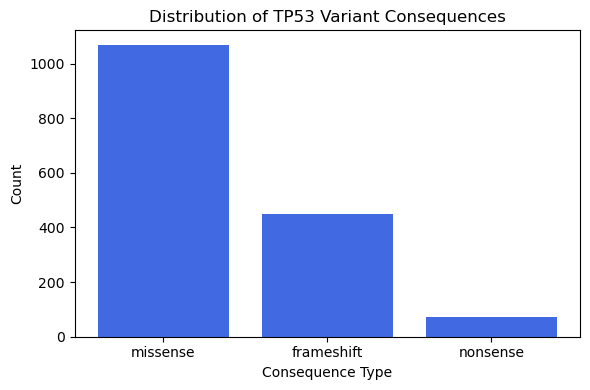

In [29]:
# Count mutation consequence types
consequence_counts = df_plot["Consequence"].value_counts().reset_index()
consequence_counts.columns = ["Consequence", "Count"]

# Split multi-condition rows and flatten into one list
all_cancers = (
    df_plot["Cancer_Type"]
    .dropna()
    .str.split(",")
    .explode()
    .str.strip()
    .replace("", pd.NA)
    .dropna()
)

# Count frequency of unique cancer terms
top_cancers = (
    all_cancers.value_counts()
    .head(5)
    .reset_index()
    .rename(columns={"index": "Cancer_Type", "Cancer_Type": "Count"})
)
top_cancers.columns = ["Cancer_Type", "Count"]

print("=== Variant Consequence Distribution ===")
display(consequence_counts)

print("\n=== Top 5 Cancer Types Associated with TP53 Variants ===")
display(top_cancers)

# Inline bar plot
plt.figure(figsize=(6,4))
plt.bar(consequence_counts["Consequence"], consequence_counts["Count"], color="royalblue")
plt.title("Distribution of TP53 Variant Consequences")
plt.ylabel("Count")
plt.xlabel("Consequence Type")
plt.tight_layout()
plt.show()